In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import optuna

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score




In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim,dropout1,dropout2):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1=nn.Dropout(dropout1)
        
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.dropout2=nn.Dropout(dropout2)

    def forward(self, x):
        residual = x  # 入力を保存 (ショートカット)
        out = torch.relu(self.bn1(self.fc1(x)))
        out=self.dropout1(out)

        out = self.bn2(self.fc2(out))
        out=self.dropout2(out)

        out += residual  # ショートカット接続
        return torch.relu(out)


In [15]:
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_blocks, hidden_dim, dropout1, dropout2):
        super(ResNetBinaryClassifier, self).__init__()
        self.blocks = nn.Sequential(
            *[ResidualBlock(input_dim, hidden_dim, dropout1, dropout2) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(input_dim, 1)  # 出力層

    def forward(self, x):
        x = self.blocks(x)
        x = torch.sigmoid(self.output_layer(x))  # 2値分類用シグモイド
        return x

In [16]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [17]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [18]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_dim=trial.suggest_categorical("hidden_dim",[64,128,256])
    num_blocks=trial.suggest_categorical("num_blocks",[3,4,5])
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   

    # モデルの定義
    model = ResNetBinaryClassifier(
        input_dim=X_train_tensor.shape[1],
        num_blocks=num_blocks,
        hidden_dim=hidden_dim,
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


In [19]:
device_id = 1 
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:38,130] A new study created in memory with name: no-name-79ab3df8-8588-4027-8c6a-31b8ad9808e7
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:43,786] Trial 0 finished with value: 0.26681413083353966 and parameters: {'hidden_dim': 256, 'num_blocks': 5, 'dropout1': 0.45, 'dropout2': 0.05, 'learning_rate': 0.0005918433855899806, 'weight_decay': 0.009040228295919734}. Best is t

Early stopping at epoch 24
Final MCC: 0.2668


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:46,782] Trial 1 finished with value: 0.2994352830433584 and parameters: {'hidden_dim': 256, 'num_blocks': 3, 'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.0471805609829078, 'weight_decay': 8.253438967132516e-05}. Best is trial 1 with value: 0.2994352830433584.


Early stopping at epoch 17
Final MCC: 0.2994


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:01:52,047] Trial 2 finished with value: 0.2244755939415051 and parameters: {'hidden_dim': 128, 'num_blocks': 5, 'dropout1': 0.15000000000000002, 'dropout2': 0.05, 'learning_rate': 0.0005442639229556051, 'weight_decay': 0.023828130713271136}. Best is trial 1 with value: 0.2994352830433584.


Early stopping at epoch 23
Final MCC: 0.2245


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:14,447] Trial 3 finished with value: 0.2269285812025616 and parameters: {'hidden_dim': 128, 'num_blocks': 5, 'dropout1': 0.35000000000000003, 'dropout2': 0.25, 'learning_rate': 0.00011133791969358479, 'weight_decay': 0.0015906254761713784}. Best is trial 1 with value: 0.2994352830433584.


Final MCC: 0.2269


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:18,358] Trial 4 finished with value: 0.18998022666296369 and parameters: {'hidden_dim': 256, 'num_blocks': 4, 'dropout1': 0.15000000000000002, 'dropout2': 0.2, 'learning_rate': 0.0007046507331169004, 'weight_decay': 0.023905863517872532}. Best is trial 1 with value: 0.2994352830433584.
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: sugges

Early stopping at epoch 19
Final MCC: 0.1900


[I 2024-12-12 21:02:18,728] Trial 6 pruned. 
[I 2024-12-12 21:02:27,251] Trial 7 finished with value: 0.30535305915376365 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.0011183864016925116, 'weight_decay': 8.90770112077375e-05}. Best is trial 7 with value: 0.30535305915376365.
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:27,420] Tria

Early stopping at epoch 37
Final MCC: 0.3054


[I 2024-12-12 21:02:27,605] Trial 9 pruned. 
[I 2024-12-12 21:02:39,049] Trial 10 finished with value: 0.3265053619643415 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.0, 'dropout2': 0.5, 'learning_rate': 0.00016331875290221857, 'weight_decay': 1.1638308548865671e-05}. Best is trial 10 with value: 0.3265053619643415.


Early stopping at epoch 62
Final MCC: 0.3265


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:02:57,285] Trial 11 finished with value: 0.32476190476190475 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.0, 'dropout2': 0.5, 'learning_rate': 0.00010127102412322779, 'weight_decay': 1.067132175396909e-05}. Best is trial 10 with value: 0.3265053619643415.


Final MCC: 0.3248


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:09,950] Trial 12 finished with value: 0.2254109089162614 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.0001150758360433131, 'weight_decay': 1.2462209056647204e-05}. Best is trial 10 with value: 0.3265053619643415.
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform h

Early stopping at epoch 71
Final MCC: 0.2254


[I 2024-12-12 21:03:17,759] Trial 14 finished with value: 0.30023590780442755 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.0003333613014646995, 'weight_decay': 5.035995232547304e-05}. Best is trial 10 with value: 0.3265053619643415.
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:17,937] Trial 15 pruned. 


Early stopping at epoch 42
Final MCC: 0.3002


[I 2024-12-12 21:03:27,167] Trial 16 finished with value: 0.21345034975240643 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00023917959296135545, 'weight_decay': 0.09997218454953981}. Best is trial 10 with value: 0.3265053619643415.
/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:27,353] Trial 17 pruned. 


Early stopping at epoch 50
Final MCC: 0.2135


[I 2024-12-12 21:03:27,573] Trial 18 pruned. 
[I 2024-12-12 21:03:34,130] Trial 19 finished with value: 0.18350448042621648 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.00028634271300538187, 'weight_decay': 1.1982678031309827e-05}. Best is trial 10 with value: 0.3265053619643415.


Early stopping at epoch 35
Final MCC: 0.1835


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:34,354] Trial 20 pruned. 
[I 2024-12-12 21:03:34,578] Trial 21 pruned. 
[I 2024-12-12 21:03:51,773] Trial 22 finished with value: 0.17252089353322636 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.0004218087588633664, 'weight_decay': 1.0680275173898105e-05}. Best is trial 

Early stopping at epoch 79
Final MCC: 0.1725


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:52,015] Trial 23 pruned. 
[I 2024-12-12 21:03:52,248] Trial 24 pruned. 
[I 2024-12-12 21:03:52,462] Trial 25 pruned. 
[I 2024-12-12 21:03:52,691] Trial 26 pruned. 
[I 2024-12-12 21:03:58,076] Trial 27 finished with value: 0.27877282097486783 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.

Early stopping at epoch 28
Final MCC: 0.2788


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:03:58,286] Trial 28 pruned. 
[I 2024-12-12 21:03:58,512] Trial 29 pruned. 
[I 2024-12-12 21:03:58,746] Trial 30 pruned. 
[I 2024-12-12 21:03:58,955] Trial 31 pruned. 
[I 2024-12-12 21:03:59,175] Trial 32 pruned. 
[I 2024-12-12 21:03:59,414] Trial 33 pruned. 
[I 2024-12-12 21:03:59,655] Trial 34 pruned. 
[I 2024-12-12 21:04:18,110] Trial 35 finished 

Final MCC: 0.2236


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:04:18,351] Trial 36 pruned. 
[I 2024-12-12 21:04:18,535] Trial 37 pruned. 
[I 2024-12-12 21:04:18,756] Trial 38 pruned. 
[I 2024-12-12 21:04:31,652] Trial 39 finished with value: 0.2270934357735348 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00014543474594943523, 'weight_de

Early stopping at epoch 82
Final MCC: 0.2271


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:04:31,903] Trial 40 pruned. 
[I 2024-12-12 21:04:32,095] Trial 41 pruned. 
[I 2024-12-12 21:04:32,315] Trial 42 pruned. 
[I 2024-12-12 21:04:32,499] Trial 43 pruned. 
[I 2024-12-12 21:04:32,686] Trial 44 pruned. 
[I 2024-12-12 21:04:32,866] Trial 45 pruned. 
[I 2024-12-12 21:04:33,076] Trial 46 pruned. 
[I 2024-12-12 21:04:33,282] Trial 47 pruned. 


Final MCC: 0.2193


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:04:49,089] Trial 49 pruned. 
[I 2024-12-12 21:04:49,323] Trial 50 pruned. 
[I 2024-12-12 21:04:49,589] Trial 51 pruned. 
[I 2024-12-12 21:05:08,402] Trial 52 finished with value: 0.3240593575912021 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00010384521713482633, 'weight_de

Early stopping at epoch 99
Final MCC: 0.3241


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:05:27,777] Trial 53 finished with value: 0.26285714285714284 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.00011446605184070452, 'weight_decay': 1.4670925096413787e-05}. Best is trial 10 with value: 0.3265053619643415.


Final MCC: 0.2629


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:05:47,376] Trial 54 finished with value: 0.29061798236548464 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.00031048873054160647, 'weight_decay': 2.5703667047914796e-05}. Best is trial 10 with value: 0.3265053619643415.


Final MCC: 0.2906


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:05:47,617] Trial 55 pruned. 
[I 2024-12-12 21:06:11,813] Trial 56 finished with value: 0.2946096069503197 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'learning_rate': 0.00010625069444838867, 'weight_decay': 0.00021433133151450257}. Best is trial 10 with value: 0.3265053619643415.


Final MCC: 0.2946


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:12,076] Trial 57 pruned. 
[I 2024-12-12 21:06:28,928] Trial 58 finished with value: 0.2901083796939586 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.2, 'dropout2': 0.45, 'learning_rate': 0.0001426918975714013, 'weight_decay': 0.06065255677105681}. Best is trial 10 with value: 0.3265053619643415.


Early stopping at epoch 68
Final MCC: 0.2901


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:29,135] Trial 59 pruned. 
[I 2024-12-12 21:06:29,344] Trial 60 pruned. 
[I 2024-12-12 21:06:29,598] Trial 61 pruned. 
[I 2024-12-12 21:06:29,829] Trial 62 pruned. 
[I 2024-12-12 21:06:30,109] Trial 63 pruned. 
[I 2024-12-12 21:06:30,378] Trial 64 pruned. 
[I 2024-12-12 21:06:30,661] Trial 65 pruned. 
[I 2024-12-12 21:06:48,092] Trial 66 finished 

Early stopping at epoch 84
Final MCC: 0.3301


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:06:48,354] Trial 67 pruned. 
[I 2024-12-12 21:06:48,549] Trial 68 pruned. 
[I 2024-12-12 21:06:48,760] Trial 69 pruned. 
[I 2024-12-12 21:06:48,990] Trial 70 pruned. 
[I 2024-12-12 21:07:09,671] Trial 71 finished with value: 0.292856973836873 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learn

Final MCC: 0.2929


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:07:09,958] Trial 72 pruned. 
[I 2024-12-12 21:07:10,200] Trial 73 pruned. 
[I 2024-12-12 21:07:35,856] Trial 74 finished with value: 0.22955183473683494 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 0.00027173629881752743, 'weight_decay': 0.00035040887992516303}. Best is trial 

Final MCC: 0.2296


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:07:36,068] Trial 75 pruned. 
[I 2024-12-12 21:07:36,341] Trial 76 pruned. 
[I 2024-12-12 21:07:36,560] Trial 77 pruned. 
[I 2024-12-12 21:07:52,750] Trial 78 finished with value: 0.27490258014691055 and parameters: {'hidden_dim': 64, 'num_blocks': 5, 'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.00024192732104208603, 'weight_decay': 2.527221

Early stopping at epoch 72
Final MCC: 0.2749


[I 2024-12-12 21:07:53,188] Trial 80 pruned. 
[I 2024-12-12 21:07:53,460] Trial 81 pruned. 
[I 2024-12-12 21:07:53,720] Trial 82 pruned. 
[I 2024-12-12 21:07:54,004] Trial 83 pruned. 
[I 2024-12-12 21:07:54,272] Trial 84 pruned. 
[I 2024-12-12 21:07:54,502] Trial 85 pruned. 
[I 2024-12-12 21:07:54,760] Trial 86 pruned. 
[I 2024-12-12 21:07:54,975] Trial 87 pruned. 
[I 2024-12-12 21:07:55,183] Trial 88 pruned. 
[I 2024-12-12 21:08:11,319] Trial 89 finished with value: 0.2872188069922511 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.0, 'dropout2': 0.45, 'learning_rate': 0.00012280039868540536, 'weight_decay': 4.097379571030327e-05}. Best is trial 66 with value: 0.3301105465945809.


Early stopping at epoch 72
Final MCC: 0.2872


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:08:11,540] Trial 90 pruned. 
[I 2024-12-12 21:08:11,735] Trial 91 pruned. 
[I 2024-12-12 21:08:32,364] Trial 92 finished with value: 0.2659184789314576 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'learning_rate': 0.00020478680000927875, 'weight_decay': 1.1882216437981635e-05}. Best is trial 

Final MCC: 0.2659


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:08:32,640] Trial 93 pruned. 
[I 2024-12-12 21:08:32,920] Trial 94 pruned. 
[I 2024-12-12 21:08:33,195] Trial 95 pruned. 
[I 2024-12-12 21:08:55,740] Trial 96 finished with value: 0.2820872109772377 and parameters: {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 0.00013145510798448374, 'weight_de

Final MCC: 0.2821


/tmp/ipykernel_1419760/2074326936.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
/tmp/ipykernel_1419760/2074326936.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
[I 2024-12-12 21:08:56,049] Trial 97 pruned. 
[I 2024-12-12 21:08:56,322] Trial 98 pruned. 
[I 2024-12-12 21:09:09,253] Trial 99 finished with value: 0.24575353546304368 and parameters: {'hidden_dim': 64, 'num_blocks': 3, 'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.00011164480703644703, 'weight_decay': 4.454708684038653e-05}. Best is trial 6

Early stopping at epoch 75
Final MCC: 0.2458
Best Parameters:  {'hidden_dim': 64, 'num_blocks': 4, 'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 0.0003090280165750253, 'weight_decay': 0.000403495474255714}
Best Validation F1:  0.3301105465945809


In [20]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_ResNet_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/100], Loss: 0.7450
Epoch [1/100], Train Loss: 0.7450, Val Loss: 0.6780
Epoch [2/100], Loss: 0.7074
Epoch [2/100], Train Loss: 0.7074, Val Loss: 0.6588
Epoch [3/100], Loss: 0.6865
Epoch [3/100], Train Loss: 0.6865, Val Loss: 0.6440
Epoch [4/100], Loss: 0.6695
Epoch [4/100], Train Loss: 0.6695, Val Loss: 0.6351
Epoch [5/100], Loss: 0.6667
Epoch [5/100], Train Loss: 0.6667, Val Loss: 0.6306
Epoch [6/100], Loss: 0.6692
Epoch [6/100], Train Loss: 0.6692, Val Loss: 0.6266
Epoch [7/100], Loss: 0.6561
Epoch [7/100], Train Loss: 0.6561, Val Loss: 0.6218
Epoch [8/100], Loss: 0.6464
Epoch [8/100], Train Loss: 0.6464, Val Loss: 0.6220
Epoch [9/100], Loss: 0.6297
Epoch [9/100], Train Loss: 0.6297, Val Loss: 0.6180
Epoch [10/100], Loss: 0.6329
Epoch [10/100], Train Loss: 0.6329, Val Loss: 0.6134
Epoch [11/100], Loss: 0.6293
Epoch [11/100], Train Loss: 0.6293, Val Loss: 0.6103
Epoch [12/100], Loss: 0.6231
Epoch [12/100], Train Loss: 0.6231, Val Loss: 0.6064
Epoch [13/100], Loss: 0.6138
Epoch

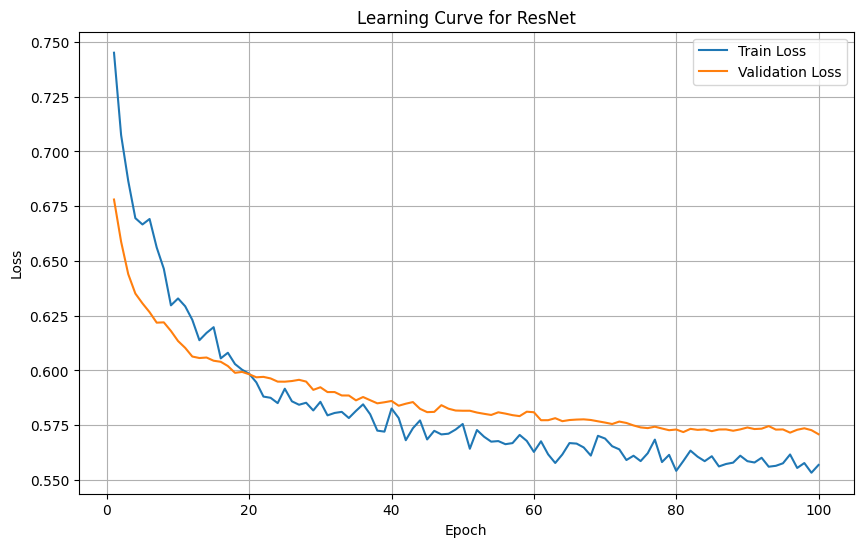

In [25]:
best_params=study.best_params
model = ResNetBinaryClassifier(input_dim=X_train_tensor.shape[1],num_blocks=best_params["num_blocks"],hidden_dim=best_params["hidden_dim"],dropout1=best_params["dropout1"],dropout2=best_params["dropout2"]).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for ResNet')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.09%
Precision: 0.4750
Recall: 0.8112
F1 Score: 0.5991
Matthews Correlation Coefficient: 0.2540
Specificity: 0.4360


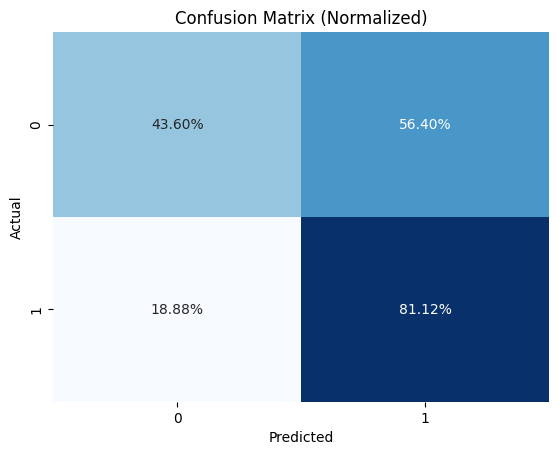

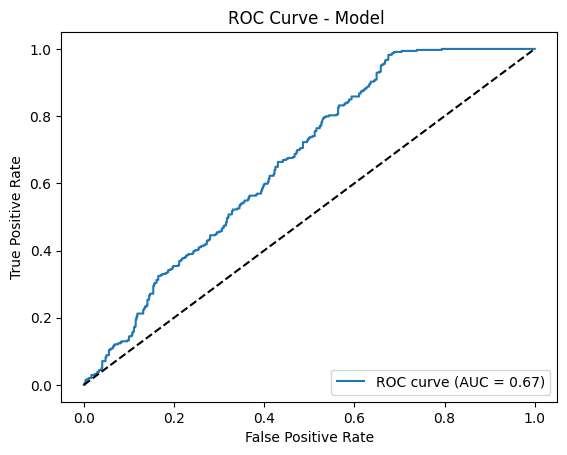

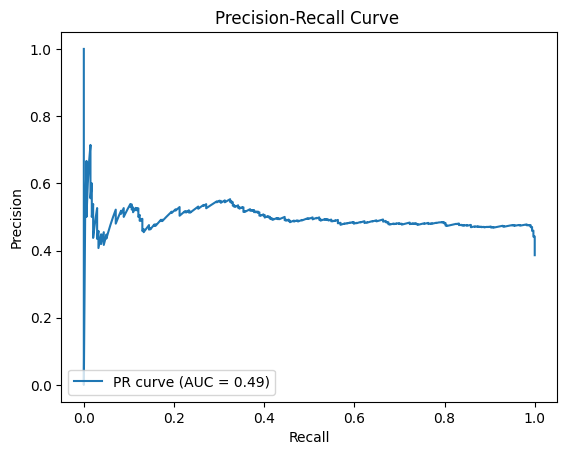

In [26]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [23]:
torch.save(model.state_dict(), 'model_params/ResNet.pth')



In [24]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,920
       BatchNorm1d-2                   [-1, 64]             128
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 29]           1,885
       BatchNorm1d-5                   [-1, 29]              58
           Dropout-6                   [-1, 29]               0
     ResidualBlock-7                   [-1, 29]               0
            Linear-8                   [-1, 64]           1,920
       BatchNorm1d-9                   [-1, 64]             128
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 29]           1,885
      BatchNorm1d-12                   [-1, 29]              58
          Dropout-13                   [-1, 29]               0
    ResidualBlock-14                   